# ANALYSIS OF REAL DATA (GSFC)

From real MnKa1, MnKa2 (+other lines) data, it creates a library of optimal filters and reconstruct (and calibrate) data calculating FWHM of lines

**Energy units are (k)eV**

Imports and definitions

PROCESSING

0. Reconstruct data file (singles) with selected record length and library Ka1 and select HR events

1. Read reconstructed events

    1.1. Have a look to events distribution and to variations with baseline and jitter
   
   STUDY OF MnK COMPLEX

2. Jitter correction

    2.1 Plot recon PH vs PHASE (distance between trigger and parabola fit=PHI+LAGS) & Fit a polynomial
    
3. Baseline drift correction

    3.1 Plot jiterr_recon PH vs Baseline & Fit polynomial
    
    3.2 Fit gaussians, create new Gain scale and re-calibrate energies
    
4. Fit histogram of baseline-jitter-corrected energies

    4.1. Test different number of bins and see how residuals respond
    
    4.2. Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then take median value
    
5. Recalibrate energies

6. Plot ALL calibrated energies (No correction for non Mn energies)
    - get new gain scale with fitted line centres
    - recalibrate energies
    - fit again to get FWHM more precisely
    
7. Plot FWHM comparison of different reconstruction methods/lengths    
        

## Imports and definitions

In [1]:
import ipywidgets as widgets
#%matplotlib widget

from subprocess import check_call, STDOUT
import os
from astropy.io import fits
import numpy.polynomial.polynomial as poly
from numpy.polynomial import Polynomial as P
import tempfile
from datetime import datetime
import shutil, shlex
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas
import heasoftpy as hsp
from RxLines import RxLines
from fit2GaussAndRatio import fit2GaussAndRatio
from getMaximaDensity import getMaximaDensity
from fit2gauss2hist import fit2gauss2hist
from fit3gauss2hist import fit3gauss2hist
from gainScaleFit import gainScaleLinearFit, gainScalePolyFit
from fitVoigt2hist import fitVoigt2hist
from applyCorr import applyCorr
from commands import run_comm
from clean_records import remove_invalid_records
from annote import AnnoteFinder
from GSFC import *
from correct_signal import correct_signal


import matplotlib.transforms as transforms
from matplotlib.gridspec import GridSpec
from numpy import random
from calibLines import *

import glob
from pathlib import Path
import shutil
import subprocess

from numina.array.wavecalib.crosscorrelation import periodic_corr1d

cwd = os.getcwd()
tmpDir = tempfile.mkdtemp()
os.environ["PFILES"] = tmpDir + ":" + os.environ["PFILES"]
os.environ["HEADASNOQUERY"] = ""
os.environ["HEADASPROMPT"] = "/dev/null/"
xmlfileSX = os.environ["SIXTE"] + "/share/xifusim/instruments/8pix_tdm.xml" # to reconstruct files with SIRENA (grading)
print(xmlfileSX)

/home/ceballos/sw/SIXTE/git/gitInstall/share/xifusim/instruments/8pix_tdm.xml


In [2]:
%%script false --no-raise-error
def correct_signal(inputdf, colname, sortby, 
                   nbins=200, xwidth=101, max_iterations=5,
                   plots=True, movie_filename=None, movie_nframes=150):
    """Auxiliary function to compute an iterative correction.
    
    The values in 'colname' are corrected by cross-correlating
    local histograms with an averaged histogram. The procedure is
    iterated in order to improve the averaged histogram after each
    applied correction.
    
    Parameters
    ----------
    inputdf : Pandas DataFrame
        Input dataframe containing the data to be corrected. Note
        that this input dataframe is not modified (a deep copy is
        performed before introducing any change).
    colname : string
        Column name with the data to be corrected.
    sortby : string
        Column name to be used to sort 'colname' and perform
        the correction.
    nbins : int
        Number of bins to generate the histogram of 'colname'.
    xwidth : int
        Number of samples in the X direction to generate local
        histograms that will be cross-correlated with the averaged
        histogram.
    max_iterations : int
        Maximum number of iterations to be performed.
    plots : bool
        If True, display intermediate plots.
    movie_filename : str or None
        Filename for movie (the program ffmpeg is required). 
        If the file name is None, no movie is generated. Otherwise,
        the individual frames are stored in a 'movie' subdirectory,
        which is created if not found. Existing frames in the 'movie'
        subdirectory are removed prior the generation of the movie file.
    movie_nframes : int
        Number of frames to be generated prior to the movie generation.
    
    Returns
    -------
    df : Pandas DataFrame
        Copy of the initial dataframe with a new column containing the
        corrected data. The new column is named as '{1}_c{2}' with
        1=colname and 2=sortby. For example, if colname='INDEX' and 
        sortby='TIME', the new column name will be 'INDEX_cTIME'.
        Note that this output dataframe is sorted by 'sortby'.
    
    """
    
    df = inputdf.copy(deep=True)
    df = df.sort_values(sortby)
    df = df.reset_index(drop=True)
    
    # total number of rows in dataframe
    lendf = len(df)

    newcolname = '{}_c{}'.format(colname, sortby)
    print('Creating new column in data frame with name: {}'.format(newcolname))
    
    # check movie subdirectory 
    if movie_filename is not None:
        if shutil.which('ffmpeg') is None:
            raise SystemError("'ffmpeg' executable not found!")
        istep_movie = int(lendf / movie_nframes)
        if istep_movie < 1:
            istep_movie == 1
        p = Path('movie')
        if p.exists():
            if p.is_dir():
                print('Subdirectory movie/ found!')
                ldum = glob.glob('movie/frame_*png')
                if len(ldum) > 0:
                    for item in ldum:
                        os.remove(item)
            else:
                raise SystemError("'movie' found but it is not a subdirectory!")
        else:
            os.mkdir('movie')
    
    # minimum and maximum SIGNAL value
    # Note: it is important to add extra room for zero padding
    ymin = df[colname].min()
    ymax = df[colname].max()
    dy = ymax - ymin
    ymin -= dy/2
    ymax += dy/2

    # compute reference histogram
    bins = np.linspace(ymin, ymax, nbins+1)  # compute bins
    deltabin = (bins[-1]-bins[0])/nbins      # bin size
    print('deltabin: {}'.format(deltabin))
    numref, dum = np.histogram(df[colname].values, bins=bins, density=True)
    xcenter = (bins[1:] + bins[:-1]) / 2     # center of each bin

    yoffset_iterations = []  # store here yoffset computed in each iteration
    
    loop = True
    iteration = 0

    # main loop
    while loop:
        print('Working: iteration #{}'.format(iteration))

        # compute correction
        xoffset = []
        yoffset = []
        for i in range(0, lendf):
            indexini = i - int(xwidth/2)
            indexini = max(indexini, 0)
            indexend = i + int(xwidth/2)
            indexend = min(indexend, lendf)
            num, dum = np.histogram(df[colname].values[indexini:indexend], bins=bins, density=True)
            offset, fpeak = periodic_corr1d(numref, num)
            xoffset.append(df[sortby].values[i])
            yoffset.append(offset)
            
            if iteration == max_iterations:
                if movie_filename is not None:
                    if (i % istep_movie == 0) or (i == (lendf - 1)):
                        fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(12,12))
                        ax1, ax2 = axarr
                        ax1.plot(xcenter, num, '-', color='c2', label='sample histogram')
                        ax1.plot(xcenter, numref, '-', color='c0', linewidth=5, label='averaged histogram')
                        ax1.legend()
                        ax1.set_xlabel(colname)
                        ax1.set_ylabel('density')
                        ax1.set_ylim([0, 300])
                        ax1.legend()
                        ax2.plot(df[sortby], df[colname], '.')
                        ax2.plot(np.array(xoffset), np.array(yoffset) * deltabin + (bins[0]+bins[-1])/2, 'o')
                        ymin, ymax = ax2.get_ylim()
                        ax2.fill_between(df[sortby].values[[indexini, indexend-1]], [ymin]*2, [ymax]*2, alpha=0.3, color='C2')
                        ax2.set_xlabel(sortby)
                        ax2.set_ylabel(colname)
                        plt.tight_layout()
                        plt.savefig('movie/frame_{:06d}.png'.format(i))
                        plt.close()

        xoffset = np.array(xoffset)
        yoffset = np.array(yoffset)
        
        yoffset_iterations.append(yoffset)

        # apply correction
        df[newcolname] = df[colname].values - yoffset * deltabin

        # recompute reference histogram
        numref, dum = np.histogram(df[newcolname].values, bins=bins, density=True)

        if iteration > 0:
            differences = yoffset_iterations[iteration-1] - yoffset
            q25 = np.percentile(differences, 25)
            q75 = np.percentile(differences, 75)
            sigmag = 0.7413 * (q75 - q25)
            print('-> robust r.m.s. of differences (deltabin): {}'.format(sigmag))

        iteration += 1
        if iteration > max_iterations:
            loop = False

        if loop:
            yoffset_previous_iteration = yoffset.copy()

    if movie_filename is not None:
        # generate movie file with ffmpeg
        command = 'ffmpeg -framerate 8 -i movie/frame_%*.png -vcodec libx264 -r 30 -crf 0 -preset veryslow -y movie/{}'.format(movie_filename)
        print('$ {}'.format(command))
        p = subprocess.Popen(command, shell=True)
        p.wait()
    
    if plots:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        ax.plot(df[sortby], df[colname], '.', alpha=0.5, color='C0', label=colname)
        ax.set_xlabel(sortby)
        ax.set_ylabel(colname)
        ax.legend()
    
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        for i in range(max_iterations+1):
            ax.plot(xoffset, yoffset_iterations[i]*deltabin, label='iteration #{}'.format(i))
        ax.set_ylabel('{} correction'.format(colname))
        ax.set_xlabel(sortby)
        # create right Y axis with ratio
        ax2 = ax.twinx()
        mean_energy = (bins[0]+bins[-1])/2
        ax2.plot(xoffset, (yoffset_iterations[-1]*deltabin+mean_energy)/mean_energy)
        ax2.ticklabel_format(useOffset=False)
        ax2.set_ylabel("Correction factor")
        ax.legend()
    
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))
        ax.plot(df[sortby], df[colname], '.', alpha=0.5, label=colname)
        ax.plot(df[sortby], df[newcolname], '.', alpha=0.5, label=newcolname)
        ax.plot(xoffset, yoffset*deltabin +(bins[0]+bins[-1])/2, '-', lw=5, color='white')
        ax.plot(xoffset, yoffset*deltabin +(bins[0]+bins[-1])/2, '-', label='correction')
        ax.set_xlabel(sortby)
        ax.set_ylabel(colname)
        ax.legend()
    
    return df


In [3]:
# data files
# 32 channels/column * 8 columns
ncols = 8
nrows = 32
channels_matrix = np.zeros((32,8),dtype="i")
for i in range(nrows):
    for j in range(ncols):
        iinit=j*nrows*2 + 1
        ifin=iinit + nrows*2 
        channels_matrix[:,j]=list(range(iinit, ifin, 2))
#print(channels_matrix)
        
channel = "5"
resDir = "channel_" + channel
if not os.path.exists(resDir):
    os.makedirs(resDir)
fileph_singles = resDir + "/pulse_chan" + channel + "_singles.fits" # initial data file with all records and PH_ID column populated
fileph_Kas = resDir + "/pulse_chan" + channel + "_Kas.fits" # data file with only those records with Kas lines (selected by max(ADC))

channel_col = int(int(channel)/(nrows*2))
print("Matrix column for channel", channel, "is column number", channel_col)   

#noXTfile = resDir + "/dataKas_noXT.csv"
noXTfile = resDir + "/Kas_noXT_PHID.csv"

Matrix column for channel 65 is column number 1


In [4]:
# select SIRENA parameters for library Kas creation and reconstruction of data files
samprate=195312.5
plen = 8000
#plen=4096 # for 0-padding
oflen = 8000
preBuffer = 2000
pBstr = ""
if preBuffer > 0:
    pBstr = "_pB" + str(preBuffer)
method = "OPTFILT"
F0orB0 = "F0"
nS = 5
sU = 3
sD = 4

thS = channels_noise_thS[channels_ids.index(channel)]
suffix = pBstr + "_filt_thS" + str(thS)


In [5]:
# reconstructed files
evt_libKas = resDir + "/" + "evt_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + ".fits"
evt_libKas_HR = resDir + "/" + "evt_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + "_HR.fits"
evtKas_libKas = resDir + "/" + "evtKas_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + ".fits"
evtKas_libKas_HR = resDir + "/" + "evtKas_pulse_chan" + channel + "_libKas_" + "pL" + str(plen) + "_" + method + str(oflen) + suffix + "_HR.fits"

# library Kas
libKas = resDir + "/" + "library_Kas_"+ str(oflen) + suffix + ".fits"

In [6]:
# gain scale
#lines = (MnKa2_cmass, MnKa1_cmass, MnKb_cmass)
lines = (MnKa2_cmass, MnKa1_cmass, MnKb.energies_eV[MnKb.ilabels.index("Kb1")])
print("MnKa2_cmass, MnKa1_cmass, MnKb1")
print(lines)

MnKa2_cmass, MnKa1_cmass, MnKb1
('5887.37', '5898.00', 6490.89)


In [7]:
def format_axes(fig):
    for i, ax in enumerate(fig.axes):
        ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
        ax.tick_params(labelbottom=False, labelleft=False)

# PROCESSING

## 0. Reconstruct data file (singles & Kas) with selected record length and select HR events
(try different record lengths to get variation of FWHM)

In [8]:
%%script false --no-raise-error
#reconstruct ALL events
comm = ("tesreconstruction Recordfile=" + fileph_singles + " TesEventFile=" + evt_libKas + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
        " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
mess = "Reconstructing ALL data w/ library (Kas)"
run_comm(comm,msg=mess)
print("####################################")
print("Reconstruction of ALL pulses finished")
print("####################################")

In [9]:
%%script false --no-raise-error
#reconstruct Mn Kas events
comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + evtKas_libKas + " PulseLength=" + str(plen) +
        " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
        " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=" + str(oflen) + " preBuffer=" + str(preBuffer))
mess = "Reconstructing Kas data w/ library (Kas)"
run_comm(comm,msg=mess)
print("####################################")
print("Reconstruction of Kas pulses finished")
print("####################################")

In [10]:
%%script false --no-raise-error
# select only HR events (ALL)
expr = "(GRADE1 >= " + str(min(plen,oflen)) + " && GRADE2 > 500)"
result = hsp.fselect(infile=evt_libKas, outfile=evt_libKas_HR, expr=expr, clobber="yes")

In [11]:
%%script false --no-raise-error
# select only HR events (Mn Kas)
expr = "(GRADE1 >= " + str(min(plen,oflen)) + " && GRADE2 > 500)"
result = hsp.fselect(infile=evtKas_libKas, outfile=evtKas_libKas_HR, expr=expr, clobber="yes")

## 1. Read reconstructed (ALL) events

In [12]:
pulseFile = resDir + "/pulse.txt"
colname = "SIGNAL, TIME, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN" 
infile = evt_libKas_HR + "+1"
print("FDUMPing evt file", infile)
result = hsp.fdump(wrap='yes', infile=infile, columns=colname, rows='-', prhead='no', showcol='yes', showunit='no',
                   showrow='no', outfile=pulseFile, clobber='yes', pagewidth=256, more='yes')

all_singles_data_HR = pandas.read_csv(pulseFile, skiprows=0,sep="\s+")
print("\nNumber of initial (all energies) HR pulses:", len(all_singles_data_HR)) 
os.remove(pulseFile)

# exclude events with PHI=0. It'll mean that there is a pulse (undetected) over the rise of another one
data_HR_goodPHI = all_singles_data_HR[(all_singles_data_HR.PHI>0.) | (all_singles_data_HR.PHI<0)].copy()
print("\nNumber of non-excluded events (all energies) HR pulses (after PHI selection):", len(data_HR_goodPHI)) 
print("MinBSLN, MaxBSLN=", min(data_HR_goodPHI.BSLN), max(data_HR_goodPHI.BSLN))

bsln_th = np.mean(data_HR_goodPHI.BSLN) + 10*np.std(data_HR_goodPHI.BSLN)
# exclude high baseline events: they have a truncated pulse at the beginnig of the record
data_HR_goodPHI_goodBSLN = data_HR_goodPHI[(data_HR_goodPHI.BSLN<bsln_th)].copy()
print("\nNumber of non-excluded events (all energies) HR pulses (after BSLN selection):", len(data_HR_goodPHI_goodBSLN)) 

data_HR = data_HR_goodPHI_goodBSLN.copy()
print("MinSIGNAL, MaxSIGNAL=", min(data_HR.SIGNAL), max(data_HR.SIGNAL))
print("MinBSLN, MaxBSLN=", min(data_HR.BSLN), max(data_HR.BSLN))
display(data_HR)
alldata_pdframe = resDir + "/allData_recons.csv"
#data_HR.to_csv(alldata_pdframe)

FDUMPing evt file channel_65/evt_pulse_chan65_libKas_pL4096_OPTFILT8000_pB2000_filt_thS3.4_HR.fits+1

Number of initial (all energies) HR pulses: 38619

Number of non-excluded events (all energies) HR pulses (after PHI selection): 38616
MinBSLN, MaxBSLN= 7225.960573476703 7822.6180235535085

Number of non-excluded events (all energies) HR pulses (after BSLN selection): 38608
MinSIGNAL, MaxSIGNAL= 1.695872148006566 14.069376906466989
MinBSLN, MaxBSLN= 7225.960573476703 7321.955453149001


,SIGNAL,TIME,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,7.411962,1.578693e+09,0,4096,4096,-0.243801,0,7298.466462
1,7.922069,1.578693e+09,1,4096,4096,-0.257055,0,7296.853047
2,7.424696,1.578693e+09,2,4096,4096,0.491859,0,7298.484383
3,7.416814,1.578693e+09,4,4096,4096,0.383089,0,7297.732207
4,7.904450,1.578693e+09,5,4096,4096,0.095715,0,7294.722478
...,...,...,...,...,...,...,...,...
38614,7.395055,1.578743e+09,42446,4096,4096,0.304772,0,7265.803379
38615,7.415996,1.578743e+09,42447,4096,4096,-0.025471,0,7267.079877
38616,7.422593,1.578743e+09,42448,4096,4096,-0.074639,0,7266.974910
38617,7.423722,1.578743e+09,42449,4096,4096,-0.337343,0,7265.871992


### 1.1 Have a look to (ALL) events distribution and to variations with baseline and jitter

In [13]:
# main lines in reconstructed PH units
PHlines = dict()
if plen==8000:
    PHlines = {
           "Sc-Ka": (4.250,4.400),
           "Ti-Ka": (4.675,4.750),
           "V-Ka":  (5.050,5.125),
           "Cr-Ka": (5.400,5.600),
           "Mn-Ka": (5.860,5.920),
           #"Mn-Ka": (5.875,5.910),
           "Fe-Ka": (6.250,6.350),
           "Mn-Kb": (6.340,6.400),
           "Co-Ka": (6.630,6.800),
           "Ni-Ka": (7.050,7.150),
           "Cu-Ka": (7.450,7.550),
           "Zn-Ka": (7.900,7.950),
           "Ge-Ka": (8.700,8.790),
           "Br-Ka": (9.800,10.100)
    } 
elif plen==4096 and channel=="5":
    PHlines = {
           "Sc-Ka": (6.250,6.350),
           "Ti-Ka": (6.650,6.730),
           "V-Ka":  (7.000,7.100),
           "Cr-Ka": (7.400,7.550),
           "Mn-Ka": (7.830,7.880),
           "Fe-Ka": (8.200,8.300),
           "Mn-Kb": (8.310,8.350),
           "Co-Ka": (8.600,8.730),
           "Ni-Ka": (9.050,9.100),
           "Cu-Ka": (9.400,9.550),
           "Zn-Ka": (9.850,9.950),
           "Ge-Ka": (10.700,10.790),
           "Br-Ka": (11.900,12.050)
    }
elif plen==4096 and channel=="13":
    PHlines = {
           "Sc-Ka": (6.250,6.350),
           "Ti-Ka": (6.650,6.730),
           "V-Ka":  (7.000,7.100),
           "Cr-Ka": (7.400,7.550),
           "Mn-Ka": (10.100,10.300),
           "Fe-Ka": (8.200,8.300),
           "Mn-Kb": (10.660,10.690),
           "Co-Ka": (8.600,8.730),
           "Ni-Ka": (9.050,9.100),
           "Cu-Ka": (9.400,9.550),
           "Zn-Ka": (9.850,9.950),
           "Ge-Ka": (10.700,10.790),
           "Br-Ka": (11.900,12.050)
    }
elif plen==4096 and channel=="65":
    PHlines = {
           "Sc-Ka": (6.250,6.350),
           "Ti-Ka": (6.650,6.730),
           "V-Ka":  (7.000,7.100),
           "Cr-Ka": (7.400,7.550),
           "Mn-Ka": (7.400,7.435),
           "Fe-Ka": (7.510,7.610),
           "Mn-Kb": (7.890,7.935),
           "Co-Ka": (8.600,8.730),
           "Ni-Ka": (9.050,9.100),
           "Cu-Ka": (9.400,9.550),
           "Zn-Ka": (9.850,9.950),
           "Ge-Ka": (10.700,10.790),
           "Br-Ka": (11.900,12.050)
    }


(7890.0, 7935.0)

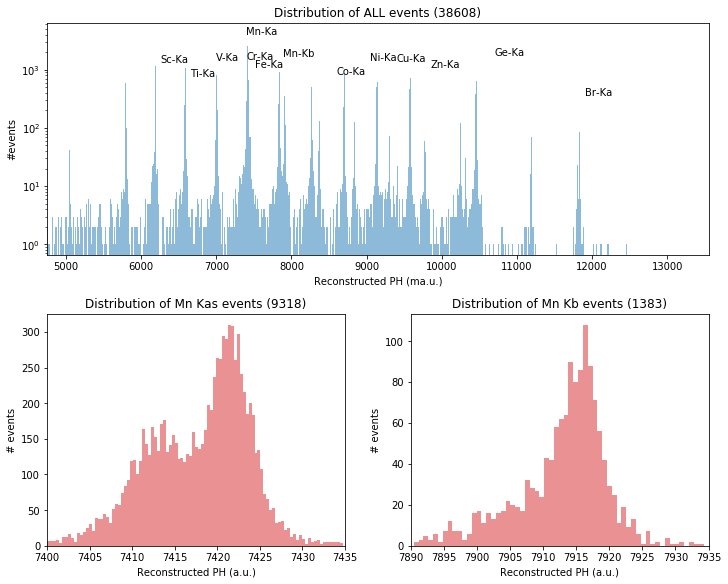

In [14]:
#%%script false --no-raise-error

# Events PH distribution
plt.close()
fig = plt.figure(constrained_layout=True, figsize=(10,8))
gs = GridSpec(2, 2, figure=fig)

# Have a look to histogram of ALL reconstructed data
ax1 = fig.add_subplot(gs[0, :])
npulses = len(data_HR.SIGNAL)
ax1.set_xlabel("Reconstructed PH (ma.u.)")
ax1.set_ylabel("#events")
ax1.set_title(("Distribution of ALL events (" + str(npulses) + ")"))
ax1.hist(1e3*data_HR.SIGNAL, bins=2000, density=False, label="Histogram", alpha=0.5, log=True)
xmin = 1e3*PHlines["Sc-Ka"][0] - 1500
xmax = 1e3*PHlines["Br-Ka"][1] + 1500
ax1.set_xlim(xmin,xmax)
for line in PHlines:
    PHmin,PHmax = PHlines[line]
    if line == "Mn-Ka":
        ax1.text(1e3*PHmin, 4e3, line)
    else:
        ax1.text(1e3*PHmin, 3e3*random.uniform(0.1,0.7), line)

# Have a look to histogram of Mn Kas
ax2 = fig.add_subplot(gs[1, 0])
minPH,maxPH = PHlines["Mn-Ka"]
npulses = len(data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL)
ax2.hist(1e3*data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL, bins=100, density=False, label="Histogram", alpha=0.5, color="tab:red")
ax2.set_xlabel("Reconstructed PH (a.u.)")
ax2.set_ylabel("# events")
ax2.set_title(("Distribution of Mn Kas events (" + str(npulses) + ")"))
ax2.set_xlim(1e3*minPH,1e3*maxPH)
#ax3.set_xlim(8650,8900) # 0-pad 2048
#ax3.set_xlim(9750,9900) # 0-pad 1024

# Have a look to histogram of Kb
ax3 = fig.add_subplot(gs[1, 1])
(minPH,maxPH) = PHlines["Mn-Kb"]
#(minKb,maxKb) = (9.210, 9.310) # 0-pad 2048
#(minKb,maxKb) = (10.275, 10.350) # 0-pad
npulses = len(data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL)
ax3.hist(1e3*data_HR[(data_HR.SIGNAL>minPH) & (data_HR.SIGNAL<maxPH)].SIGNAL, bins=60, density=False, label="Histogram", alpha=0.5, color="tab:red")
ax3.set_xlabel("Reconstructed PH (a.u.)")
ax3.set_ylabel("# events")
ax3.set_title(("Distribution of Mn Kb events (" + str(npulses) + ")"))
ax3.set_xlim(1e3*minPH,1e3*maxPH)
#ax4.set_xlim(9210,9310) # 0-pad 2048
#ax4.set_xlim(10275,10350) # 0-pad 1024



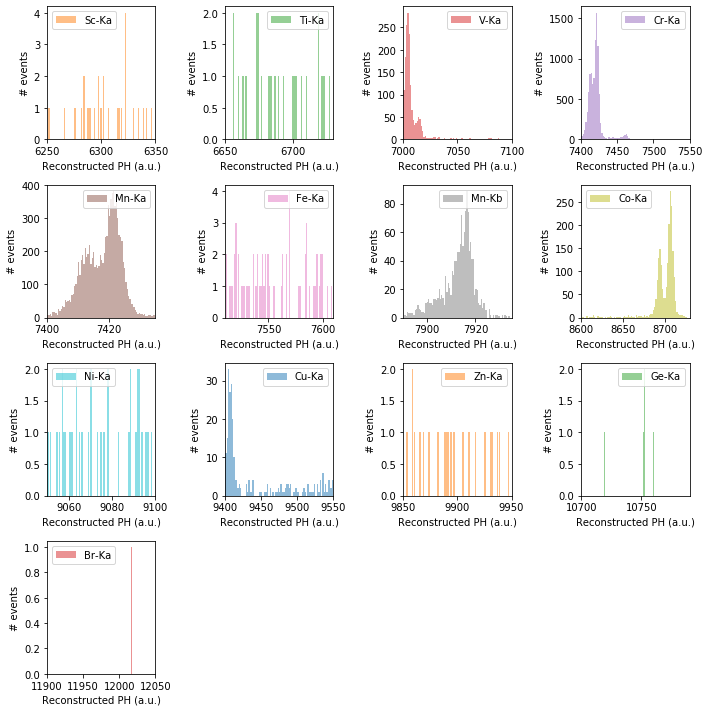

In [15]:
fig = plt.figure(figsize=(10,10))
i = 0
for line in PHlines:
    i+=1
    color="C"+str(i)
    #print("Plotting line=", PHlines[line])
    PHmin,PHmax = PHlines[line]
    npulses = len(data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)].SIGNAL)
    ax = fig.add_subplot(4, 4, i)
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)].SIGNAL
    ax.hist(1e3*dataLine, bins=80, density=False, alpha=0.5, color=color, label=line)
    ax.set_xlabel("Reconstructed PH (a.u.)")
    ax.set_ylabel("# events")
    ax.set_xlim(1e3*PHmin,1e3*PHmax)
    ax.legend()

fig.tight_layout()


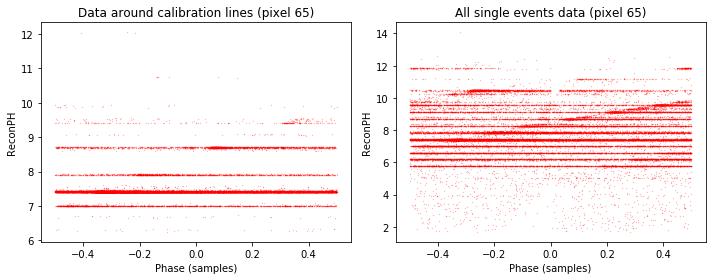

In [16]:
# plot jitters
plt.close()
phase_HR = data_HR.PHI + data_HR.LAGS
base_HR = data_HR.BSLN

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlabel("Phase (samples)")
ax1.set_ylabel("ReconPH")
 
for line in PHlines:
    PHmin,PHmax = PHlines[line]
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
    phase_HR = dataLine.PHI + dataLine.LAGS
    phase_HR = dataLine.PHI 
    # arrival phase to (-0.5,0.5) interval
    lagPhase = phase_HR - 1.*np.trunc(phase_HR/0.5)
    ax1.scatter(lagPhase, dataLine.SIGNAL, alpha=0.5,s=0.05, color="red")
    tit = "Data around calibration lines (pixel " + channel + ")"
    ax1.set_title(tit)
    #ax1.scatter(phase_HR, dataLine.LAGS, alpha=0.5)
    
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlabel("Phase (samples)")
ax2.set_ylabel("ReconPH")
#lagPhase = all_singles_data_HR.PHI - 1.*np.trunc(all_singles_data_HR.PHI/0.5)
#ax2.scatter(lagPhase, all_singles_data_HR.SIGNAL, alpha=0.5,s=0.05, color="blue")
lagPhase = data_HR.PHI - 1.*np.trunc(data_HR.PHI/0.5)
#lagPhase = data_HR.PHI
ax2.scatter(lagPhase, data_HR.SIGNAL, alpha=0.5,s=0.05, color="red")
#ax2.set_ylim(3.5,10.5)
tit = "All single events data (pixel " + channel + ")"
ax2.set_title(tit)
fig.tight_layout()

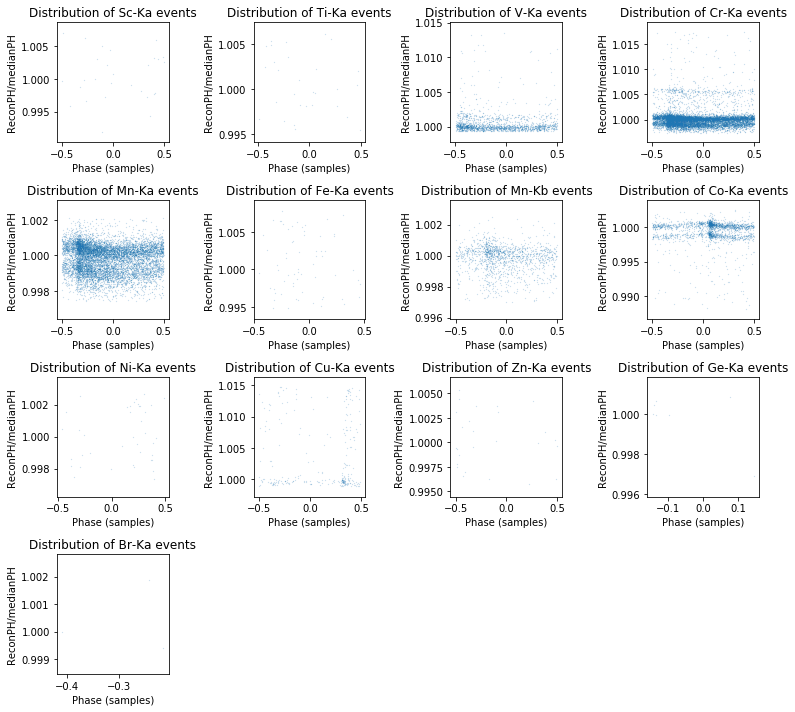

In [17]:
fig = plt.figure(figsize=(11,10))
i = 0
for line in PHlines:
    i+=1
    #print("Plotting line=", PHlines[line])
    PHmin,PHmax = PHlines[line]
    dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
    dataLine_norm = dataLine.SIGNAL/(np.median(dataLine.SIGNAL))
    phase_HR = dataLine.PHI + dataLine.LAGS
    phase_HR = dataLine.PHI - 1.*np.trunc(dataLine.PHI/0.5)
    ax1 = fig.add_subplot(4, 4, i)
    ax1.set_xlabel("Phase (samples)")
    ax1.set_ylabel("ReconPH/medianPH")
    title = "Distribution of " + line + " events"
    ax1.set_title(title)
    ax1.scatter(phase_HR, dataLine_norm, alpha=0.5,s=0.03)
    #ax1.scatter(phase_HR, dataLine.LAGS, alpha=0.5)

fig.tight_layout()

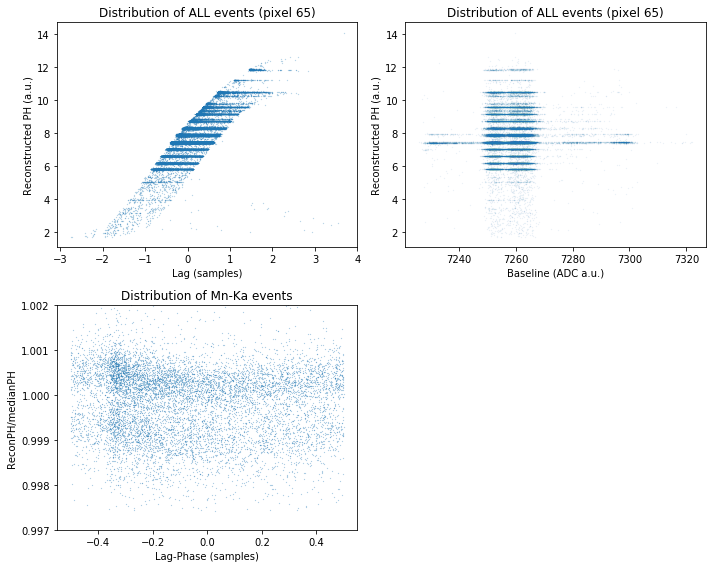

In [18]:
# Jitter and baseline distribution
plt.close()
phase_HR = data_HR.PHI + data_HR.LAGS
base_HR = data_HR.BSLN

tit = "Distribution of ALL events (pixel " + channel + ")"

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel("Lag (samples)")
ax1.set_ylabel("Reconstructed PH (a.u.)")
ax1.set_title(tit)
ax1.scatter(phase_HR, data_HR.SIGNAL, alpha=0.6, s=0.04)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel("Baseline (ADC a.u.)")
ax2.set_ylabel("Reconstructed PH (a.u.)")
ax2.set_title(tit)
ax2.scatter(base_HR, data_HR.SIGNAL, alpha=0.2, s=0.03)

line = "Mn-Ka"
PHmin,PHmax = PHlines[line]
dataLine = data_HR[(data_HR.SIGNAL>PHmin) & (data_HR.SIGNAL<PHmax)]
dataLine_norm = dataLine.SIGNAL/(np.median(dataLine.SIGNAL))
phase_HR = dataLine.PHI - 1.*np.trunc(dataLine.PHI/0.5)
ax3 = fig.add_subplot(2, 2, 3)
ax3.set_xlabel("Lag-Phase (samples)")
ax3.set_ylabel("ReconPH/medianPH")
title = "Distribution of " + line + " events"
ax3.set_title(title)
ax3.scatter(phase_HR, dataLine_norm, alpha=0.8,s=0.03)
ax3.set_ylim(0.997,1.002)
fig.tight_layout()

# STUDY Mn K complex 

## 1. Read reconstructed (Kas) events

In [19]:
pulseFile = resDir + "/pulse.txt"
colname = "TIME,SIGNAL, PH_ID, GRADE1, GRADE2, PHI, LAGS, BSLN" 
infile = evtKas_libKas_HR + "+1"
print("FDUMPing evt file", infile)
result = hsp.fdump(wrap='yes', infile=infile, columns=colname, rows='-', prhead='no', showcol='yes', showunit='no',
                   showrow='no', outfile=pulseFile, clobber='yes', pagewidth=256, more='yes')

dataKas_HR = pandas.read_csv(pulseFile, skiprows=0,sep="\s+")
#print("\nNumber of initial (all energies) HR pulses:", len(data_HR)) 
os.remove(pulseFile)
if len(dataKas_HR[dataKas_HR.PHI == 0.].PHI >0):
    print("Warning: some dataKas have PHI==0. => double undetected pulse?")

display(dataKas_HR)
print("MinSIGNAL, MaxSIGNAL=", min(dataKas_HR.SIGNAL), max(dataKas_HR.SIGNAL))



FDUMPing evt file channel_65/evtKas_pulse_chan65_libKas_pL4096_OPTFILT8000_pB2000_filt_thS3.4_HR.fits+1


,TIME,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,1.578693e+09,7.411962,0,4096,4096,-0.243801,0,7298.466462
1,1.578693e+09,7.424696,2,4096,4096,0.491859,0,7298.484383
2,1.578693e+09,7.416814,4,4096,4096,0.383089,0,7297.732207
3,1.578693e+09,7.417712,6,4096,4096,-0.254095,0,7298.093702
4,1.578693e+09,7.415533,7,4096,4096,0.257032,0,7296.883257
...,...,...,...,...,...,...,...,...
8461,1.578743e+09,7.423147,42445,4096,4096,0.423306,0,7267.282642
8462,1.578743e+09,7.415996,42447,4096,4096,-0.025471,0,7267.079877
8463,1.578743e+09,7.422593,42448,4096,4096,-0.074639,0,7266.974910
8464,1.578743e+09,7.423722,42449,4096,4096,-0.337343,0,7265.871992


MinSIGNAL, MaxSIGNAL= 7.3938646583482015 7.4435570193320135


## 0. Remove XT from files in same TDM column

In [20]:
%%script false --no-raise-error
# reconstruct pulses in the other files of the same column
for ich in channels_matrix[:,channel_col]:
    colDir = "channel_" + str(ich)
    if not os.path.exists(colDir):
        os.makedirs(colDir)


In [21]:
%%script false --no-raise-error
t1 = 0.002 # (s) dT backwards according to GSFC doc
t2 = 0.002 # (s) dT forwards
time_window = [t1, t2]

In [22]:
%%script false --no-raise-error
# create a small lib no prebuffer on small filters to get pixel events detections
tmpFile = resDir + "/" + "pp" + str(int(datetime.timestamp(datetime.now()))) + ".fits"
thS = channels_noise_thS[channels_ids.index(channel)]
ns_suffix = "_filt_thS" + str(thS)
noisefile = resDir + "/noise_chan" + channel + ns_suffix + "_spec.fits"
simple_lib = resDir + "/simple_lib.fits"
comm = ("tesreconstruction Recordfile=" + fileph_Kas + " TesEventFile=" + tmpFile + " PulseLength=" + str(plen) +
        " LibraryFile=" + simple_lib + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + 
        " samplesDown=" + str(sD) + " opmode=0 FilterMethod=" + F0orB0 + 
        " clobber=yes EnergyMethod=" + method + " largeFilter=64" + 
        " NoiseFile=" + noisefile + " monoenergy=" + str(MnKas_cmass) + 
        " preBuffer=0")
#print(comm)
run_comm(comm, "Building final library (Kas)")
os.remove(tmpFile)

In [23]:
%%script false --no-raise-error
# reconstruct events in Lower res mode, because only ARRIVAL TIME (detection) is interesting 
print ("Reconstructing events for colum of channel", channel)
print(channel_col)
print(channels_matrix[:,channel_col])
print(channel)
#print(fileXT)
#input("stop")
for ich in channels_matrix[:,channel_col]:
    if ich==int(channel):
        continue
    file_same_col = "/datar2/pulse_chan" + str(ich) + ".fits"
    fileXT = "pulse_detection_chan" + str(ich) + ".fits" #Full events file in channel ich
    if os.path.isfile(file_same_col) and not os.path.isfile(fileXT) :
        comm = ("tesreconstruction Recordfile=" + file_same_col + " TesEventFile=" + fileXT + " PulseLength=" + str(plen) +
            " LibraryFile=" + libKas + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
            " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
            " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=4096 preBuffer=2000 LagsOrNot=1")
        #comm = ("tesreconstruction Recordfile=" + file_same_col + " TesEventFile=" + fileXT + " PulseLength=" + str(plen) +
        #    " LibraryFile=" + simple_lib + " samplesUp=" + str(sU) + " nSgms=" + str(nS) + " samplesDown=" + str(sD) +
        #    " opmode=1 clobber=yes EnergyMethod=" + method + " XMLFile=" + xmlfileSX + " LbT=0.01" + 
        #    " filtEeV=" + str(MnKas_cmass) + " OFStrategy=FIXED OFLength=64 preBuffer=0")
        mess = "detecting pulses for channel:" + str(ich)
        #print(comm)
        run_comm(comm,msg=mess)


In [24]:
%%script false --no-raise-error
dataKas_noXT = dataKas_HR.copy() # inititalize non-XT events
print("Starting with non-XT", len(dataKas_noXT.SIGNAL)," Kas events in channel", channel)
# Select only non-XT events
for ich in channels_matrix[:,channel_col]:
    if str(ich)==channel:
        continue
    print ("Analysing events in channel", ich)
    fileXT = "pulse_detection_chan" + str(ich) + ".fits" #Full events file in channel ich
    if os.path.isfile(fileXT) :
        f = fits.open(fileXT)
        TIMExt = f["EVENTS"].data['TIME']
        PHIDxt = f["EVENTS"].data['PH_ID']
        f.close()
        # look for events in fileXT synchronous with evts in fileph_Kas    
    
        xt0 = len(dataKas_noXT.TIME)
        for i in range(len(TIMExt)):
            #dataKas_noXT = dataKas_noXT[(abs(dataKas_noXT.TIME-TIMExt[i])>sepTH)]
            dataKas_noXT = dataKas_noXT[((dataKas_noXT.TIME-TIMExt[i])>t1) | 
                                       ((TIMExt[i]-dataKas_noXT.TIME)>t2)] 
            #dataKas_XT = dataKas_HR[(abs(dataKas_HR.TIME-TIMExt[i])<sepTH)]
            #if len(dataKas_XT.TIME >0):
            #    display(dataKas_HR[(abs(dataKas_HR.TIME-TIMExt[i])<sepTH)])
            #time_dist = np.abs(np.array(dataKas_HR.TIME)-TIMExt[i])
            #idx_close = np.argwhere(time_dist < sepTH)[:,0]
            #if len(idx_close)>0:
            #    print("XT photon", i, "in channel", ich, "is very close to Kas photon(s) in df row:",idx_close)
        xt1 = len(dataKas_noXT.TIME)    
        if xt1 < xt0:
            diff=xt0-xt1
            print("Removed",diff,"photons from channel",channel," which have (channel",ich,") XT photons in pulse length")
            print("Current number of non-XT events in channel", channel," is ", len(dataKas_noXT.TIME))

Starting with non-XT 8466  Kas events in channel 65
Analysing events in channel 67


NameError: name 't1' is not defined

In [ ]:
%%script false --no-raise-error
rem = len(dataKas_HR.TIME) - len(dataKas_noXT.TIME)
print("Initial Kas photons:", len(dataKas_HR.TIME))
print("Removed", rem, "photons from channel", channel, "list")
print("Remining photons:", len(dataKas_noXT.TIME))
display(dataKas_noXT)
Kas_noXT_PHID = dataKas_noXT.PH_ID.to_numpy()
display(Kas_noXT_PHID)

In [25]:
# save or read file with PH_ID of non-XT events (reconstruction method changes pandas datasets (SIGNAL, PHI))
if os.path.isfile(noXTfile):
    Kas_noXT_PHID = np.loadtxt(noXTfile)
else:
    np.savetxt(noXTfile, Kas_noXT_PHID)
dataKas_noXT = dataKas_HR[(dataKas_HR.PH_ID.isin(Kas_noXT_PHID))].copy()
display(dataKas_noXT)

,TIME,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN
0,1.578693e+09,7.411962,0,4096,4096,-0.243801,0,7298.466462
1,1.578693e+09,7.424696,2,4096,4096,0.491859,0,7298.484383
3,1.578693e+09,7.417712,6,4096,4096,-0.254095,0,7298.093702
4,1.578693e+09,7.415533,7,4096,4096,0.257032,0,7296.883257
5,1.578693e+09,7.420186,8,4096,4096,0.274902,0,7299.859191
...,...,...,...,...,...,...,...,...
8461,1.578743e+09,7.423147,42445,4096,4096,0.423306,0,7267.282642
8462,1.578743e+09,7.415996,42447,4096,4096,-0.025471,0,7267.079877
8463,1.578743e+09,7.422593,42448,4096,4096,-0.074639,0,7266.974910
8464,1.578743e+09,7.423722,42449,4096,4096,-0.337343,0,7265.871992


In [26]:
dataKas_noXT['PHI05'] = dataKas_noXT['PHI'] - np.trunc(dataKas_noXT['PHI']/0.5)
print("Kas pandas table")
dataKas_noXT

Kas pandas table


,TIME,SIGNAL,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN,PHI05
0,1.578693e+09,7.411962,0,4096,4096,-0.243801,0,7298.466462,-0.243801
1,1.578693e+09,7.424696,2,4096,4096,0.491859,0,7298.484383,0.491859
3,1.578693e+09,7.417712,6,4096,4096,-0.254095,0,7298.093702,-0.254095
4,1.578693e+09,7.415533,7,4096,4096,0.257032,0,7296.883257,0.257032
5,1.578693e+09,7.420186,8,4096,4096,0.274902,0,7299.859191,0.274902
...,...,...,...,...,...,...,...,...,...
8461,1.578743e+09,7.423147,42445,4096,4096,0.423306,0,7267.282642,0.423306
8462,1.578743e+09,7.415996,42447,4096,4096,-0.025471,0,7267.079877,-0.025471
8463,1.578743e+09,7.422593,42448,4096,4096,-0.074639,0,7266.974910,-0.074639
8464,1.578743e+09,7.423722,42449,4096,4096,-0.337343,0,7265.871992,-0.337343


In [27]:
PHminKb, PHmaxKb = PHlines["Mn-Kb"]
# dataKas_HR already read above; dataKb not corrected for XT!
dataKb_HR = data_HR[(data_HR.SIGNAL>PHminKb) & (data_HR.SIGNAL<PHmaxKb)].copy()
dataKb_HR['PHI05'] = dataKb_HR['PHI'] - np.trunc(dataKb_HR['PHI']/0.5)
print("Kb pandas table")
dataKb_HR

Kb pandas table


,SIGNAL,TIME,PH_ID,GRADE1,GRADE2,PHI,LAGS,BSLN,PHI05
1,7.922069,1.578693e+09,1,4096,4096,-0.257055,0,7296.853047,-0.257055
4,7.904450,1.578693e+09,5,4096,4096,0.095715,0,7294.722478,0.095715
9,7.896196,1.578693e+09,10,4096,4096,-0.015222,0,7297.801331,-0.015222
10,7.919206,1.578693e+09,11,4096,4096,-0.008585,0,7298.579621,-0.008585
11,7.896814,1.578693e+09,12,4096,4096,-0.185332,0,7298.915515,-0.185332
...,...,...,...,...,...,...,...,...,...
38368,7.919760,1.578743e+09,42178,4096,4096,0.171612,0,7265.089606,0.171612
38405,7.907953,1.578743e+09,42217,4096,4096,0.071643,0,7264.566308,0.071643
38458,7.906939,1.578743e+09,42282,4096,4096,0.042865,0,7266.177163,0.042865
38605,7.913565,1.578743e+09,42436,4096,4096,-0.121506,0,7264.839222,-0.121506


## 2. TIME correction

Creating new column in data frame with name: SIGNAL_cTIME
deltabin: 0.0004969236098381202
Working: iteration #0
Working: iteration #1
-> robust r.m.s. of differences (deltabin): 0.14838553137910607
Working: iteration #2
-> robust r.m.s. of differences (deltabin): 0.027487375994217054
Working: iteration #3
-> robust r.m.s. of differences (deltabin): 0.008743840601033922


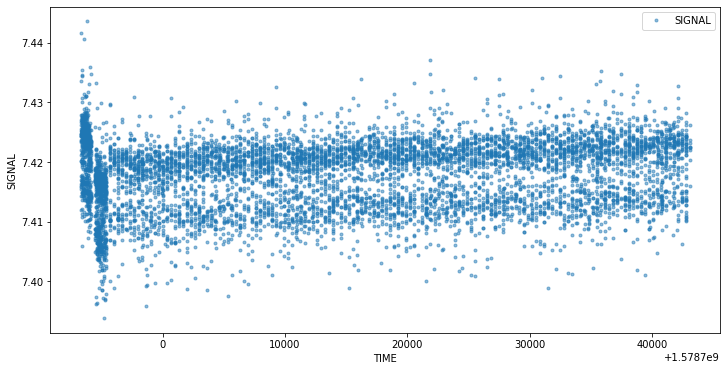

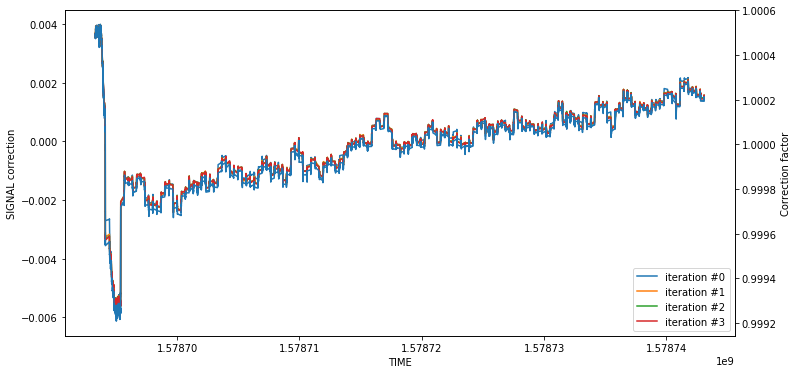

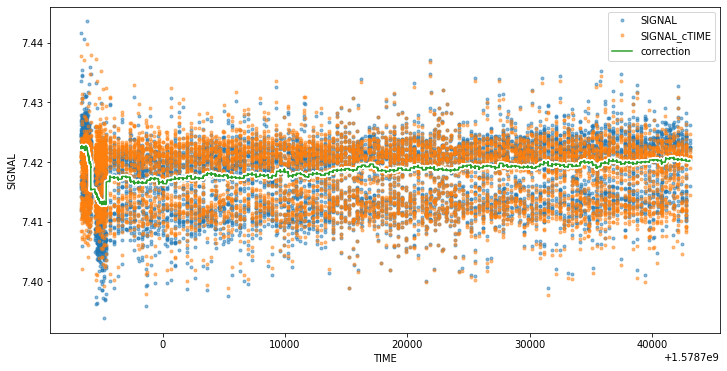

In [28]:
dataKas_HR_drift= correct_signal(inputdf=dataKas_noXT, colname="SIGNAL", sortby="TIME", 
                                 max_iterations=3)

Creating new column in data frame with name: SIGNAL_cTIME
deltabin: 0.00043794320783584694
Working: iteration #0
Working: iteration #1
-> robust r.m.s. of differences (deltabin): 0.5521887864510372
Working: iteration #2
-> robust r.m.s. of differences (deltabin): 0.18285181177962612
Working: iteration #3
-> robust r.m.s. of differences (deltabin): 0.09043465826719346


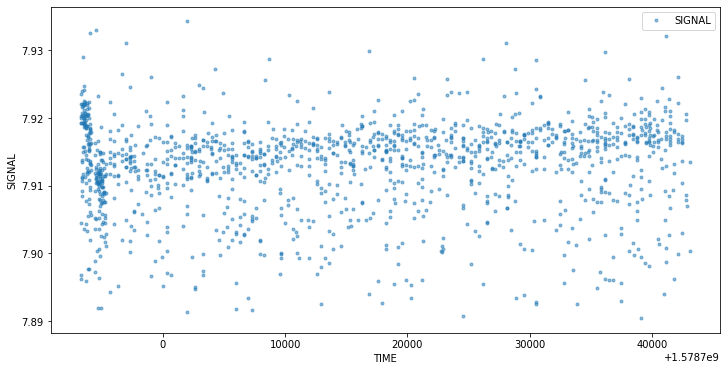

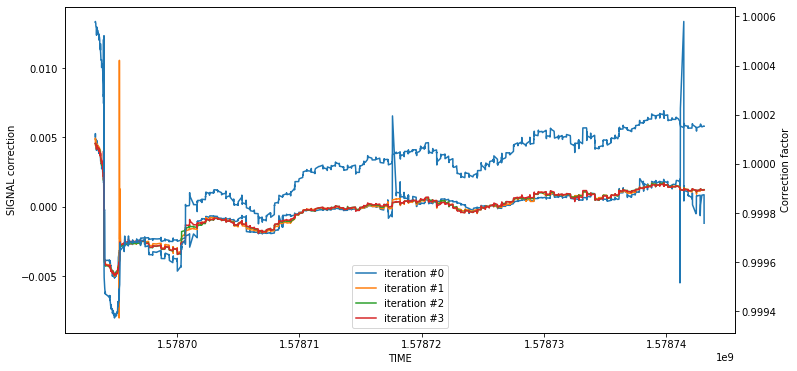

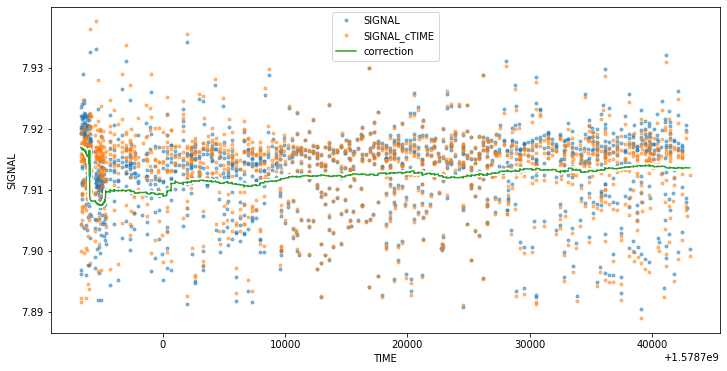

In [29]:
dataKb_HR_drift= correct_signal(inputdf=dataKb_HR, colname="SIGNAL", sortby="TIME", max_iterations=3)

### 2.1 Plot Pulse Height vs PHASE (distance between trigger and parabola fit = PHI) & fit polynomial
Phase = PHI
Lags = PHI + LAGS

Creating new column in data frame with name: SIGNAL_cTIME_cPHI05
deltabin: 0.0004194274339263249
Working: iteration #0
Working: iteration #1
-> robust r.m.s. of differences (deltabin): 0.11548436911874302
Working: iteration #2
-> robust r.m.s. of differences (deltabin): 0.012888174263107295
Working: iteration #3
-> robust r.m.s. of differences (deltabin): 0.0047884650549823715


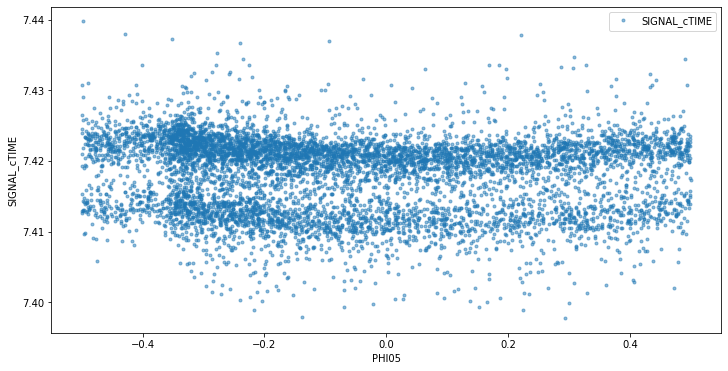

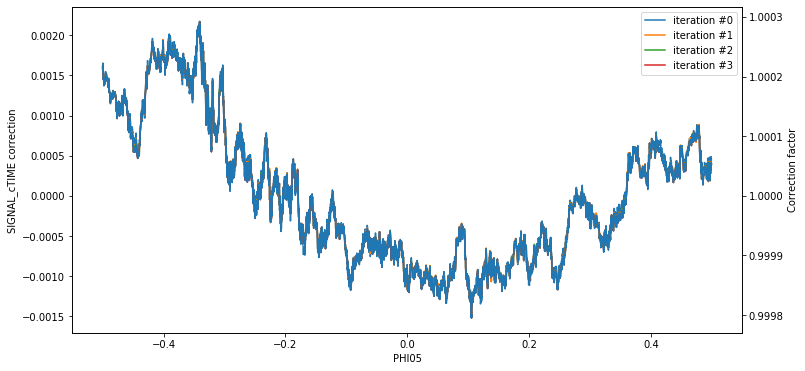

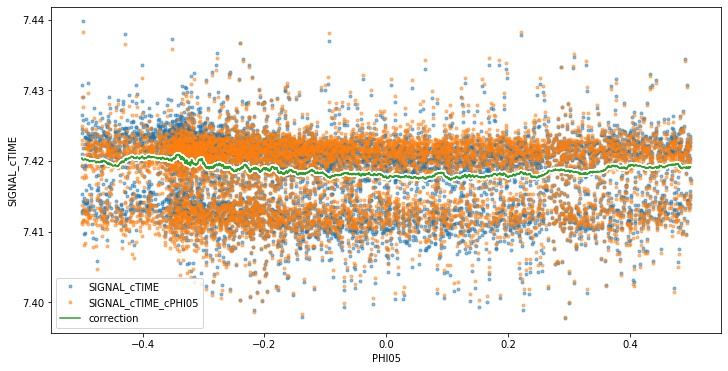

In [30]:
#dataKas_HR_drift_jitter = correct_signal(inputdf=dataKas_HR_drift, colname="SIGNAL_cTIME", 
#                                         sortby="PHI05", max_iterations=3, xwidth=501, 
#                                         movie_filename="channel_5_jitter.mp4")
dataKas_HR_drift_jitter = correct_signal(inputdf=dataKas_HR_drift, colname="SIGNAL_cTIME", 
                                         sortby="PHI05", max_iterations=3, xwidth=101)

Creating new column in data frame with name: SIGNAL_cTIME_cPHI05
deltabin: 0.0004858212110794558
Working: iteration #0
Working: iteration #1
-> robust r.m.s. of differences (deltabin): 0.11659162319658728
Working: iteration #2
-> robust r.m.s. of differences (deltabin): 0.03712237742477087
Working: iteration #3
-> robust r.m.s. of differences (deltabin): 0.03935885585411929


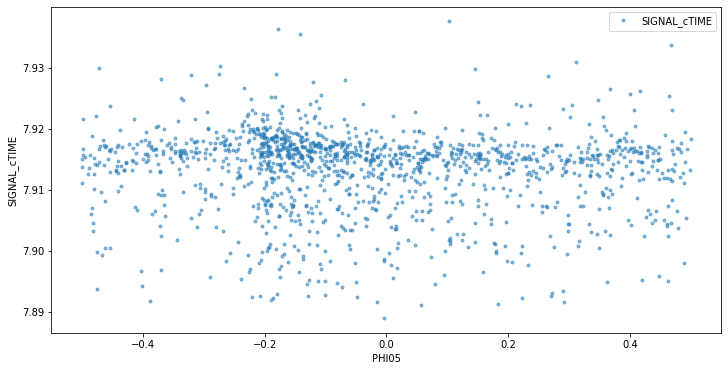

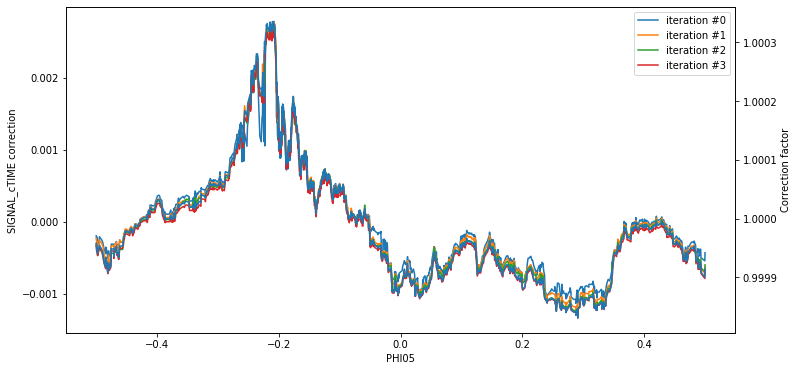

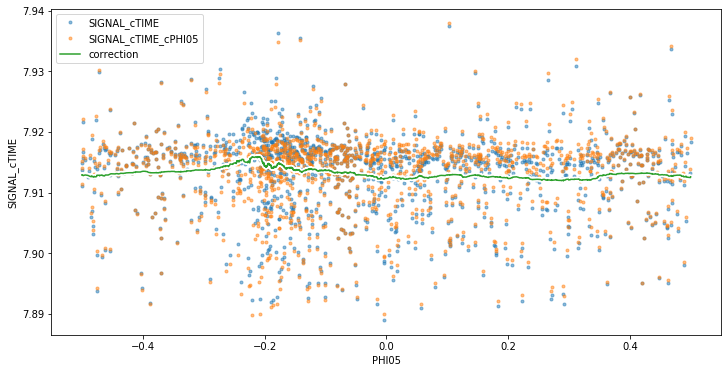

In [31]:
dataKb_HR_drift_jitter = correct_signal(inputdf=dataKb_HR_drift, colname="SIGNAL_cTIME", sortby="PHI05", max_iterations=3)

## 3. Baseline correction

In [ ]:
%%script false --no-raise-error
dataKas_HR_drift_jitter_bsln = correct_signal(inputdf=dataKas_HR_drift_jitter, 
                                              colname="SIGNAL_cTIME_cPHI05", sortby="BSLN", max_iterations=3)

In [32]:
############## SELECT THE LEVEL OF CORRECTION (NICO'S) ###################################
dataKas_HR_corrected = np.copy(dataKas_HR_drift_jitter.SIGNAL_cTIME_cPHI05)  
dataKb_HR_corrected = np.copy(dataKb_HR_drift_jitter.SIGNAL_cTIME_cPHI05)  

#print(len(dataKas_HR_corrected))
#print(dataKas_HR_corrected[0:10])

corrected = "drift_jitter"

## 4. Fit gaussians, create Gain scale and calibrate energies

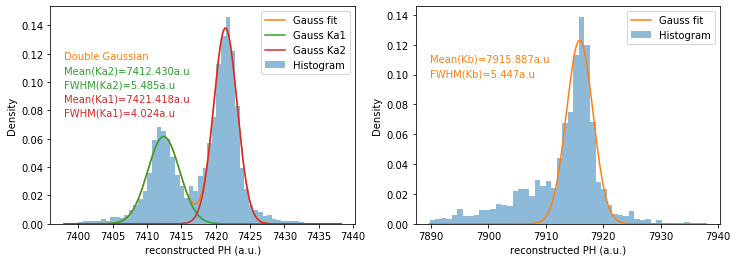

In [33]:
# Pre-calibration histogram
plt.close()
nbinsKas = 60
nbinsKb = 50
if plen == 8000:
    centresA=[5889,5898] # for pL8000
    centresB=6368
elif plen == 4096:
    centresA=[7855,7865] # for pL4096 & channels 5,65
    centresB=8345 # for pL4096 & channels 5,65
    centresA=[10195,10205] #for pL4096 & channels 13
    centresB=10682 #for pL4096 & channels 13
    centresA=[7412,7422] # for pL4096 & channels 65
    centresB=7900 # for pL4096 & channels 65
(mean1bsln, mean2bsln, mean3bsln) = fit3gauss2hist(data1=1e3*dataKas_HR_corrected, data2=1e3*dataKb_HR_corrected,
                                        a1=0.06, a2=0.12, a3=0.1, sig1=5, sig2=5, sig3=5, 
                                        mean1=centresA[0], mean2=centresA[1], mean3=centresB,
                                        nbins1=nbinsKas, nbins2=nbinsKb, 
                                        xlab="reconstructed PH (a.u.)", plot=True, xsize=12,ysize=4)

In [34]:
# create gain scale Ka2, Ka1, Kb
#plt.close()
calib_lines = tuple([float(x) for x in (lines)])
recon_lines = (mean1bsln,mean2bsln, mean3bsln)

#calib_lines = tuple([float(x) for x in (lines[0:2])])
#print(calib_lines)
#recon_lines = (mean1bsln,mean2bsln)

coefs = gainScalePolyFit(xData=recon_lines, yData=calib_lines, deg=2, ylab="MnK Lines energies (eV)", xsize=10, ysize=4)
print("gain scale coefs=", coefs)

RMSE: 4.265908282671653e-12
R-squared: 1.0
gain scale coefs= [-1.10266181e+03  7.03542670e-01  3.23068383e-05]


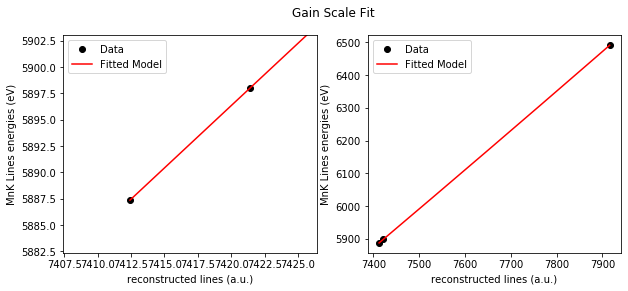

In [35]:
minEeV_Ka=5860
maxEeV_Ka=5920
#minEeV_Ka=5880
#maxEeV_Ka=5905

minEeV_Kb=6450
maxEeV_Kb=6505
# recalibrate energies
enerKas_HR_corrected = np.zeros(len(dataKas_HR_corrected))
enerKb_HR_corrected = np.zeros(len(dataKb_HR_corrected))

for i in range(len(coefs)):
    enerKas_HR_corrected += coefs[i] * (1e3*dataKas_HR_corrected)**(i)
enerKas_HR_corrected = enerKas_HR_corrected[(enerKas_HR_corrected > minEeV_Ka) & (enerKas_HR_corrected < maxEeV_Ka)]

for i in range(len(coefs)):
    enerKb_HR_corrected += coefs[i] * (1e3*dataKb_HR_corrected)**(i)
enerKb_HR_corrected = enerKb_HR_corrected[(enerKb_HR_corrected>minEeV_Kb) & (enerKb_HR_corrected<maxEeV_Kb)]


## 4 Fit histogram of corrected+gainscale_calib0 energies

#### 4.1 Test different number of bins and see how the residuals respond

In [ ]:
%%script false --no-raise-error
# Plot residuals curve to select best number of bins for Kas and Kb
plt.clf()
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=np.arange(20,200,20), ax0=ax1)
ax1.set_title("MnKas")

fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=np.arange(40,150,10), ax0=ax2)
ax2.set_title("MnKb")

#### 4.2 Use the range of number of bins where residuals are quite estable and use them to get different FWHM; then take median value

In [36]:
#%%script false --no-raise-error
# Calculate mean 'fit' for range of acceptable number of bins in Kas range
#                                                               ===========
(ibmin, ibmax) = (100, 300)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKas in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)    
    plt.clf()
    if fw < 0 or efw == 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKas)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKas = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKas[median_index]=", nbins[median_index])

print("Using ", len(fwhm_G), "different number of bins")
txt_Kas = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kas)=", txt_Kas)


FWHM_Gs= [2.400 2.389 2.416 2.433 2.433 2.425 2.400 2.406 2.419 2.401 2.412 2.418
 2.404 2.403 2.408 2.418 2.422 2.409 2.414 2.415]
median_index= 10
FWHM_G[median_index]= 2.411644598737876
ERR_FWHM_G[median_index]= 0.0736377170184115
nbinsKas[median_index]= 200
Using  20 different number of bins
Median FWHM_G(Kas)= 2.41+/-0.07eV


<Figure size 432x288 with 0 Axes>

In [37]:
#%%script false --no-raise-error

# Calculate mean 'fit' for range of acceptable number of bins in Kb range
#                                                               ===========
(ibmin, ibmax) = (50, 100)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKb in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)    
    plt.clf()
    if efw == 0 or fw < 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKb)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKb = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKb[median_index]=", nbins[median_index])

txt_Kb = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kb)=", txt_Kb)

FWHM_Gs= [2.774 2.658 2.667 2.591]
median_index= 1
FWHM_G[median_index]= 2.657557456819546
ERR_FWHM_G[median_index]= 0.1831322306305103
nbinsKb[median_index]= 70
Median FWHM_G(Kb)= 2.66+/-0.18eV


<Figure size 432x288 with 0 Axes>

Using nbinsKas= 200 from median estimation
Using nbinsKb= 70 from median estimation
2.411644598737876 0.0736377170184115
Line_fit[ 0 ]= 5898.49386 line_calib= 5898.88200 offset= -0.38814
Line_fit[ 1 ]= 5897.50992 line_calib= 5897.89800 offset= -0.38808
Line_fit[ 2 ]= 5894.47612 line_calib= 5894.86400 offset= -0.38788
Line_fit[ 3 ]= 5896.17801 line_calib= 5896.56600 offset= -0.38799
Line_fit[ 4 ]= 5899.05582 line_calib= 5899.44400 offset= -0.38818
Line_fit[ 5 ]= 5902.32361 line_calib= 5902.71200 offset= -0.38839
Line_fit[ 6 ]= 5887.38459 line_calib= 5887.77200 offset= -0.38741
Line_fit[ 7 ]= 5886.14067 line_calib= 5886.52800 offset= -0.38733
2.657557456819546 0.1831322306305103


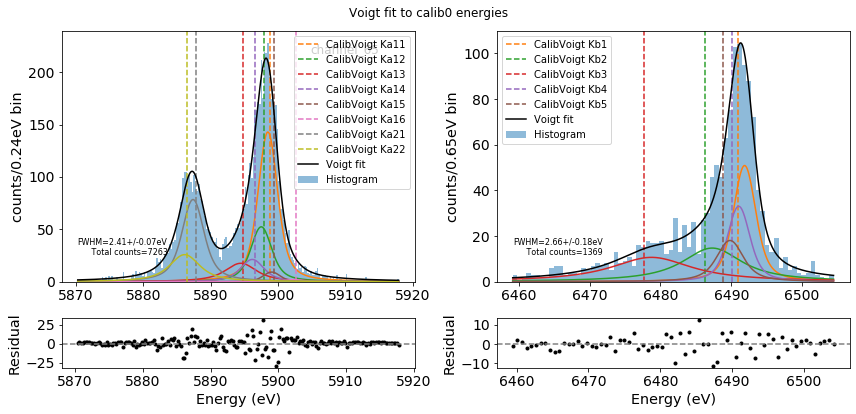

In [38]:
#%%script false --no-raise-error
#plt.close()
# Plot representative (median) fitting 
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Voigt fit to calib0 energies")
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

print("Using nbinsKas=", nbinsKas, "from median estimation")
print("Using nbinsKb=", nbinsKb, "from median estimation")

nlines_Kas = MnKas.getNumber() 
nlines_Kb = MnKb.getNumber()
nlines = nlines_Kas + nlines_Kb 
lines_centres_vv = np.zeros(nlines)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_HR_corrected, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)
print(fwhm_G, err_fwhm_G)
offset = np.zeros(nlines_Kas)
for i in range(nlines_Kas):
    lines_centres_vv[i] = vvmod.param_sets[i*4][0]
    offset[i] = lines_centres_vv[i]-MnKas.energies_eV[i]
    print("Line_fit[",i,"]=", '{:0.5f}'.format(lines_centres_vv[i]), 
          "line_calib=", '{:0.5f}'.format(MnKas.energies_eV[i]), 
          "offset=",'{:0.5f}'.format(offset[i]))
info = "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_HR_corrected))
ax1.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes, fontsize=8)
ax1.text(0.90, 0.90, resDir,verticalalignment='bottom', horizontalalignment='right',transform=ax1.transAxes, fontsize=12)

fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKb_HR_corrected, lines=MnKb, nbins=int(nbinsKb), ax0=ax2)
print(fwhm_G, err_fwhm_G)
for i in range(nlines_Kb):
    j = i + nlines_Kas
    lines_centres_vv[j] = vvmod.param_sets[i*4][0]
info = "FWHM=" + txt_Kb + "\n Total counts=" + str(len(enerKb_HR_corrected))
ax2.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax2.transAxes, fontsize=8)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [ ]:
%%script false --no-raise-error
# correct offset and fit again 
enerKas_HR_corrected_offset = enerKas_HR_corrected.copy()
enerKas_HR_corrected_offset -= np.median(offset)

(ibmin, ibmax) = (100, 300)
fwhm_G = list()
err_fwhm_G = list()
nbins = list()
for nbinsKas in np.arange(ibmin, ibmax, 10):
    fw, efw, vv_fit = fitVoigt2hist(data=enerKas_HR_corrected_offset, lines=MnKas, nbins=int(nbinsKas), ax0=ax1)    
    plt.clf()
    if efw == 0 or fw < 0:
        continue
    fwhm_G.append(fw)
    err_fwhm_G.append(efw)
    nbins.append(nbinsKas)
print("FWHM_Gs=", np.array2string(np.asarray(fwhm_G), formatter={'float_kind':lambda x: "%.3f" % x}))
median_fwhm_G = np.median(fwhm_G)
median_err_fwhm_G = np.sum(abs(np.asarray(fwhm_G)-median_fwhm_G))/len(fwhm_G)
median_index = min(range(len(fwhm_G)), key=lambda i: abs(fwhm_G[i]-median_fwhm_G))
nbinsKas = nbins[median_index]
print("median_index=", median_index)
print("FWHM_G[median_index]=",fwhm_G[median_index])
print("ERR_FWHM_G[median_index]=",err_fwhm_G[median_index])
print("nbinsKas[median_index]=", nbins[median_index])
print("Using ", len(fwhm_G), "different number of bins")
txt_Kas = '{:0.2f}'.format(median_fwhm_G) + "+/-" + '{:0.2f}'.format(max(median_err_fwhm_G, err_fwhm_G[median_index])) + "eV"
print("Median FWHM_G(Kas)=", txt_Kas)

fig = plt.figure(figsize=(8, 6))
fig.suptitle("Voigt fit to calib0 energies")
ax = fig.add_subplot(1,1,1)
fwhm_G, err_fwhm_G, vvmod = fitVoigt2hist(data=enerKas_HR_corrected_offset, lines=MnKas, nbins=int(nbinsKas), ax0=ax)
info = "FWHM=" + txt_Kas + "\n Total counts=" + str(len(enerKas_HR_corrected_offset))
ax.text(0.30, 0.10, info,verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes, fontsize=8)
ax.set_ylim(0,400)
fig.tight_layout()